![example](images/director_shot.jpeg)

# Microsoft Movie Production

**Author:** Elimelech Berlin
***

## Overview

Microsoft will be getting into the business of movie production. In this report I will be examinig available movie data to determine what types of projects have been the most profitable, and I will make recommendations based on my findings.

## Business Problem

As not all movies are created equal, producing the 'right' type of movie can be a tricky thing. There are a variety of factors that can influence the success and profitablity of a release; these factors are not always apparent. By analyzing available data about a large number of movies (both successful and unsuccessful), we can identify how certain factors impact the earnings of a film.

## Data Understanding

I will be using data from these two files: [im.db.zip](http://localhost:8888/edit/data/zippedData/im.db.zip) and [bom.movie gross.csv.gz](http://localhost:8888/edit/data/zippedData/bom.movie_gross.csv.gz). They contain data from the following movie data websites: [Box Office Mojo](https://www.boxofficemojo.com/ 'https://www.boxofficemojo.com/'), [IMDB](https://www.imdb.com/ 'https://www.imdb.com/'), [Rotten Tomatoes](https://www.rottentomatoes.com/ 'https://www.rottentomatoes.com/'), [The Movie DB](https://www.themoviedb.org/ 'https://www.themoviedb.org/') and [The Numbers](https://www.the-numbers.com/ 'https://www.the-numbers.com/').  

Included in this data is both business information and creative/content information. I will be focusing on some of the business data (earnings) but with an understanding of how it's influenced by other data (genre, language). 

In [1]:
# Import standard packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
# import library to unzip file & extract it
import zipfile as zf

with zf.ZipFile("zippedData/im.db.zip",'r') as IMDB:
    IMDB.printdir()
    IMDB.extractall('zippedData')

File Name                                             Modified             Size
im.db                                          2021-12-20 16:31:38    169443328


In [3]:
import sqlite3

In [4]:
conn = sqlite3.connect('zippedData/im.db')

In [5]:
# take a look at the bom.movie_gross.csv.gz file
bom = pd.read_csv('zippedData/bom.movie_gross.csv.gz')
bom.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3387 non-null   object 
 1   studio          3382 non-null   object 
 2   domestic_gross  3359 non-null   float64
 3   foreign_gross   2037 non-null   object 
 4   year            3387 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 132.4+ KB


In [6]:
# sample the data to get a sense of it
bom.head()

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
3,Inception,WB,292600000.0,535700000,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010


To simplify the analysis, I create a new column called 'total_gross' which is the sum of 'domestic_gross' & 'foreign_gross'.

In [7]:
# remove commas from foreign_gross values to normalize data
bom['foreign_gross'] = bom['foreign_gross'].str.replace(',', '')

In [8]:
# change data type to numeric
bom['foreign_gross'] = bom['foreign_gross'].astype(float)

In [9]:
# change null values to 0
bom['foreign_gross'] = bom['foreign_gross'].fillna(0)

In [10]:
# change null values to 0
bom['domestic_gross'] = bom['domestic_gross'].fillna(0)

In [11]:
# create column 'total_gross' by adding 'domestic_gross' & 'foreign_gross'
bom['total_gross'] = bom['domestic_gross'] + bom['foreign_gross']

# preview results
bom.head()

,title,studio,domestic_gross,foreign_gross,year,total_gross
0,Toy Story 3,BV,415000000.0,652000000.0,2010,1.067000e+09
1,Alice in Wonderland (2010),BV,334200000.0,691300000.0,2010,1.025500e+09
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000.0,2010,9.603000e+08
3,Inception,WB,292600000.0,535700000.0,2010,8.283000e+08
4,Shrek Forever After,P/DW,238700000.0,513900000.0,2010,7.526000e+08


In [12]:
# ensure that there are no null values in 'total_gross'
bom['total_gross'].isna().value_counts()

False    3387
Name: total_gross, dtype: int64

In [13]:
# check for duplicate rows
bom['title'].duplicated().value_counts()
# find duplicate row
bom[bom['title'].duplicated() == True]
# show both rows to see if they are truly duplicate
bom[bom['title'] == 'Bluebeard']

,title,studio,domestic_gross,foreign_gross,year,total_gross
317,Bluebeard,Strand,33500.0,5200.0,2010,38700.0
3045,Bluebeard,WGUSA,43100.0,0.0,2017,43100.0


Although there is more than one entry for a particular movie title, I've discovered that its not a duplicate but 2 different movies with the same title, so I'll leave them in place. 

In [14]:
# delete the 'year' column bec. it's irrelevant to my analysis
bom.drop(['year', 'studio'], axis=1, inplace=True)

The [bom.movie gross.csv.gz](http://localhost:8888/edit/zippedData/bom.movie_gross.csv.gz) file contains basic information about gross profits from movies, the studios that produced them and their release year. I deleted the year & studio columns as they are irrelevant to my investigation.  
Now, I'll get relevant data from the im.db file.

In [15]:
# get table names for im.db
pd.read_sql("""SELECT name
               FROM sqlite_schema;
               """, conn)

,name
0,movie_basics
1,directors
2,known_for
3,movie_akas
4,movie_ratings
5,persons
6,principals
7,writers


In [16]:
# get column names for all tables in im.db
col = pd.read_sql("""SELECT name
               FROM sqlite_schema;
               """, conn)

for table in col['name']:
    x = pd.read_sql("""SELECT *
                       FROM {}
                       LIMIT 1;
                       """.format(table), conn)
    print(table, x.columns)


movie_basics Index(['movie_id', 'primary_title', 'original_title', 'start_year',
       'runtime_minutes', 'genres'],
      dtype='object')
directors Index(['movie_id', 'person_id'], dtype='object')
known_for Index(['person_id', 'movie_id'], dtype='object')
movie_akas Index(['movie_id', 'ordering', 'title', 'region', 'language', 'types',
       'attributes', 'is_original_title'],
      dtype='object')
movie_ratings Index(['movie_id', 'averagerating', 'numvotes'], dtype='object')
persons Index(['person_id', 'primary_name', 'birth_year', 'death_year',
       'primary_profession'],
      dtype='object')
principals Index(['movie_id', 'ordering', 'person_id', 'category', 'job', 'characters'], dtype='object')
writers Index(['movie_id', 'person_id'], dtype='object')


In [17]:
# get a dataframe with relevant info from the movie_basics table
movie_basics = pd.read_sql("""SELECT movie_id,
                                     primary_title as title,
                                     genres
                              FROM movie_basics;
                           """, conn)
movie_basics

,movie_id,title,genres
0,tt0063540,Sunghursh,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,Drama
3,tt0069204,Sabse Bada Sukh,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,"Comedy,Drama,Fantasy"
...,...,...,...
146139,tt9916538,Kuambil Lagi Hatiku,Drama
146140,tt9916622,Rodolpho Teóphilo - O Legado de um Pioneiro,Documentary
146141,tt9916706,Dankyavar Danka,Comedy
146142,tt9916730,6 Gunn,None


In [18]:
# add the info from movie_basics table to a dataframe with revenue info
# use inner join because I can't learn anything for a movie without an ID or without any info about profit it earned
bom_basics = bom.merge(movie_basics, 'inner')
bom_basics

,title,domestic_gross,foreign_gross,total_gross,movie_id,genres
0,Toy Story 3,415000000.0,652000000.0,1.067000e+09,tt0435761,"Adventure,Animation,Comedy"
1,Inception,292600000.0,535700000.0,8.283000e+08,tt1375666,"Action,Adventure,Sci-Fi"
2,Shrek Forever After,238700000.0,513900000.0,7.526000e+08,tt0892791,"Adventure,Animation,Comedy"
3,The Twilight Saga: Eclipse,300500000.0,398000000.0,6.985000e+08,tt1325004,"Adventure,Drama,Fantasy"
4,Iron Man 2,312400000.0,311500000.0,6.239000e+08,tt1228705,"Action,Adventure,Sci-Fi"
...,...,...,...,...,...,...
3361,Souvenir,11400.0,0.0,1.140000e+04,tt2389092,"Comedy,Romance"
3362,Souvenir,11400.0,0.0,1.140000e+04,tt3478898,Documentary
3363,Beauty and the Dogs,8900.0,0.0,8.900000e+03,tt6776572,"Crime,Drama,Thriller"
3364,The Quake,6200.0,0.0,6.200000e+03,tt6523720,"Action,Drama,Thriller"


In [19]:
# create a dataframe with language info
language = pd.read_sql("""SELECT movie_id,
                                 language
                       FROM movie_akas;
                    """, conn)
language

,movie_id,language
0,tt0369610,bg
1,tt0369610,None
2,tt0369610,None
3,tt0369610,None
4,tt0369610,None
...,...,...
331698,tt9827784,None
331699,tt9827784,en
331700,tt9880178,None
331701,tt9880178,None


In [20]:
# remove duplicate rows
language = language.drop_duplicates()
language.reset_index(drop=True, inplace=True)
language['movie_id'].duplicated().value_counts()

False    122302
True      36915
Name: movie_id, dtype: int64

In [21]:
# remove rows without a givven language
language.dropna(inplace=True)
language.reset_index(drop=True, inplace=True)

<ipython-input-21-668508b25565>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  language.dropna(inplace=True)


In [22]:
# add languages dataframe to the general dataframe
bom_basics_lang = bom_basics.merge(language, how = 'left', on= 'movie_id' )

In [23]:
# check movie_basics_lang 'genres' column for null values
bom_basics_lang['genres'].isna().value_counts()

False    8672
True       40
Name: genres, dtype: int64

In [24]:
# check movie_basics_lang 'language' column for null values
bom_basics_lang['language'].isna().value_counts()

False    7771
True      941
Name: language, dtype: int64

For now I will leave null values in all columns in place but I may need to remove one or another later (such as when analyzing the apparent relationship of a movie's genre & its profitability; I can learn nothing without knowing the movie in question's genre).

In [25]:
# reorder columns for ease of use
bom_basics_lang = bom_basics_lang.reindex(columns=['movie_id', 'title', 'domestic_gross', 'foreign_gross', 'total_gross', 'genres', 'language'])
# preview result
bom_basics_lang

,movie_id,title,domestic_gross,foreign_gross,total_gross,genres,language
0,tt0435761,Toy Story 3,415000000.0,652000000.0,1.067000e+09,"Adventure,Animation,Comedy",tr
1,tt0435761,Toy Story 3,415000000.0,652000000.0,1.067000e+09,"Adventure,Animation,Comedy",cmn
2,tt0435761,Toy Story 3,415000000.0,652000000.0,1.067000e+09,"Adventure,Animation,Comedy",en
3,tt0435761,Toy Story 3,415000000.0,652000000.0,1.067000e+09,"Adventure,Animation,Comedy",bg
4,tt0435761,Toy Story 3,415000000.0,652000000.0,1.067000e+09,"Adventure,Animation,Comedy",fa
...,...,...,...,...,...,...,...
8707,tt3478898,Souvenir,11400.0,0.0,1.140000e+04,Documentary,NaN
8708,tt6776572,Beauty and the Dogs,8900.0,0.0,8.900000e+03,"Crime,Drama,Thriller",en
8709,tt6523720,The Quake,6200.0,0.0,6.200000e+03,"Action,Drama,Thriller",bg
8710,tt6523720,The Quake,6200.0,0.0,6.200000e+03,"Action,Drama,Thriller",en


# Analysis
With the dataframe of all of the relevant information assembled, I'll procede to analyze several aspects of the movies.  
I will be examinig the available information to answer 3 questions:  
* What are the most profitable movie genres?  
* Movies in what languages earn the most money?  
* Does the number of languages in which a movie is released affect earnings?

### Genres & Earnings
In this section I will examine the relationship between the particular genre(s) of a movie & its earnings. I will look to identify which genres are the most profitable. 

In [26]:
genres_df = bom_basics_lang.drop(['domestic_gross', 'foreign_gross', 'language'], axis=1)

In [27]:
# check the dataframe for null values
genres_df['genres'].isna().value_counts()

False    8672
True       40
Name: genres, dtype: int64

In [28]:
# create dataframe of rows from genres_df that have null values for genres
null_genres = genres_df[genres_df['genres'].isna()]
# drop rows in that dataframe from the genres_df dataframe
genres_df.drop(axis=0, labels = null_genres.index, inplace=True)

In [29]:
# get a view of the genres
genres_df['genres']

0       Adventure,Animation,Comedy
1       Adventure,Animation,Comedy
2       Adventure,Animation,Comedy
3       Adventure,Animation,Comedy
4       Adventure,Animation,Comedy
                   ...            
8707                   Documentary
8708          Crime,Drama,Thriller
8709         Action,Drama,Thriller
8710         Action,Drama,Thriller
8711                        Comedy
Name: genres, Length: 8672, dtype: object

I see that for movies with multiple genres listed, their genres are listed as a single combination genre. I will split those movies into multiple rows, one per genre. 

In [30]:
# check the number of rows in the genres dataframe
genres_df.shape

(8672, 4)

In [31]:
# split each genres string into a list
genres_df['genres'] = genres_df['genres'].str.split(',')

In [32]:
# create new rows for each item in each genres list
genres_df = genres_df.explode('genres')
genres_df.reset_index(drop=True, inplace=True)
# check the number of rows of the modified dataframe
genres_df.shape

(21163, 4)

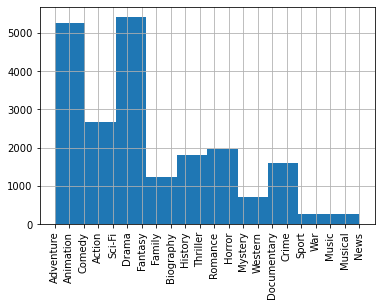

In [33]:
# ensure sufficient data per genre
genres_df['genres'].hist()
# turn the xtick labels for readability
plt.xticks(rotation= 90)
# save the plot
plt.savefig('images/genres_count_hist');

There are relatively few movies for certain genres; I'll drop those genres from my analysis as there is insufficient information to work with.

In [34]:
# filter genres_df to exclude movies with a genre with less than 250 movies in the dataframe
genres_df = genres_df[genres_df.groupby('genres')['genres'].transform('size') >= 250]

In [35]:
# group the movie data by genre to compare profitability of each genre
gnr_mean = genres_df.groupby('genres').mean()
gnr_mean.reset_index(inplace=True)
# view the dataframe
gnr_mean

,genres,total_gross
0,Action,2.461619e+08
1,Adventure,3.557658e+08
2,Animation,3.386766e+08
3,Biography,6.856765e+07
4,Comedy,1.310463e+08
5,Crime,6.894319e+07
6,Documentary,2.922057e+07
7,Drama,5.526268e+07
8,Family,1.793349e+08
9,Fantasy,2.324773e+08


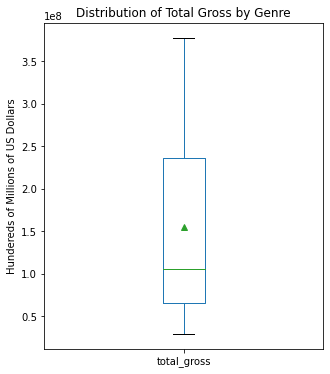

In [36]:
# get a sense of the distribution of total_gross by genre
gnr_mean.plot(title= 'Distribution of Total Gross by Genre', y = 'total_gross', ylabel= 'Hundereds of Millions of US Dollars',
              kind = 'box', showmeans=True, figsize= (5, 6))
# save the plot
plt.savefig('images/gross_by_genre_box');

We can see from the above boxplot that typical (based on mean) movies in some genres tend, on average, to produce earnings above the average genre.

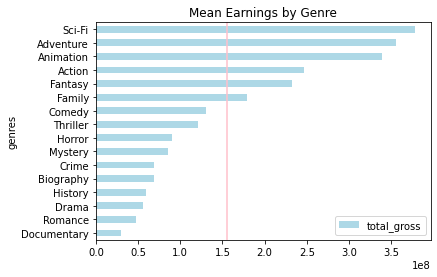

In [37]:
# reorder dataframe by earnings
gnr_mean.sort_values(by= 'total_gross', inplace=True)
# a view of average earnings by genre
gnr_mean.plot.barh(y= 'total_gross', x= 'genres', title = 'Mean Earnings by Genre', color = 'lightblue')
plt.axvline(x = gnr_mean['total_gross'].mean(), color= 'pink', label = 'mean')
# plt.ylabel('hundereds of millions of $')
plt.savefig('images/earnings_by_genre_barh', bbox_inches= 'tight');

We can clearly see which genres are the most profitable.
***

### Languages & Profitability
In this section I will explore how the earnings of movies can be affected by the language(s) in which that movie is available.

In [38]:
# remove rows without a givven language
lang_df = bom_basics_lang.dropna(subset= ['language'])
lang_df.reset_index(drop=True, inplace=True)

In [39]:
# exclude irrelevant info
lang_df.drop('genres', axis= 1, inplace=True)

C:\Users\melec\anaconda3\envs\learn-env\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [40]:
# remove languages with less than 20 movies (insufficient data)
lang_df = lang_df[lang_df.groupby('language')['language'].transform('size') >= 20]
lang_df.reset_index(drop=True, inplace=True)

In [41]:
# create dataframe of info by language
lang_group = lang_df.groupby('language')
# create dataframe of mean language info
lang_mean = lang_group.mean()
lang_mean.reset_index(inplace=True)
# reorder by earnings
lang_mean.sort_values(by= 'foreign_gross', inplace=True)

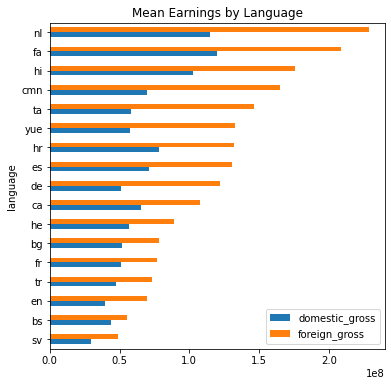

In [42]:
# view mean earnings by language
# this plot is arranged by foreign gross
lang_mean.plot.barh(x = 'language', y = ['domestic_gross', 'foreign_gross'], title= 'Mean Earnings by Language', figsize=(6,6))
# save the plot
plt.savefig('images/mean_earnings_by_lang_foreign_barh');

It's apparent from the above plots that movies in certain languages earn more money than movies in other languages. The languages that earn more money domestically are different than those that earn more abroad. Unsurprisingly, there seems to be a less pronounced affect on earnings based on language domestically than abroad. 
***

### Language Count & Revenue
In this section I will investigate the impact of the number of available languages of a film on its earnings. Do movies released in more languages make more money?

In [43]:
# create a dataframe with a column for #_of_languages
lang_df_2 = bom_basics_lang.dropna(subset= ['language'])
movie_langs = lang_df_2.groupby('movie_id').count()
movie_langs.reset_index(inplace=True)
movie_langs['#_of_languages'] = movie_langs['language']

In [44]:
# add movie earnings info to the dataframe
movie_langs = lang_df_2.merge(movie_langs[['movie_id', '#_of_languages']], on= 'movie_id')

In [45]:
# drop languge column (irrelevant for now)
movie_langs.drop('language', axis=1, inplace=True)

In [46]:
# drop extra rows for movies having more than row
movie_langs.drop_duplicates(subset= 'movie_id', inplace=True)

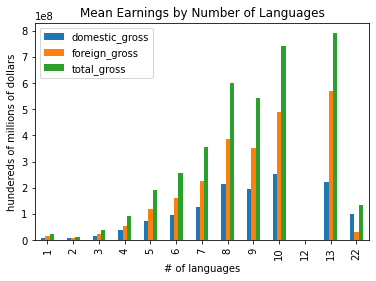

In [47]:
# get info on mean earnings of movies in multiple languages
# create a dataframe of mean info per number of languages
lang_counts_mean = movie_langs.groupby('#_of_languages').mean()
lang_counts_mean.reset_index(inplace=True)
# view plot of mean earnings per number of languages
lang_counts_mean.plot.bar(x = '#_of_languages', y = ['domestic_gross', 'foreign_gross', 'total_gross'], stacked=False)

plt.title('Mean Earnings by Number of Languages')
plt.ylabel('hundereds of millions of dollars')
plt.xlabel('# of languages')
plt.savefig('images/earnings_by_lang_#_bar');

From the above barplot it's evident that mean movie profits increase as the number of languages in which that movie is available increases. This is generally true not only of money earned abroad but even domestic earnings.  
There do seem to be 3 exceptions to the above conclusion; movies in 2, 9, 22 don't follow this pattern.
This may be attributable to something affecting the mean data used to create the above plot.  
Let's view the data on all of the movies instead of on the mean per language count.

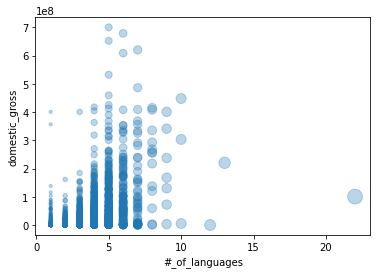

In [48]:
movie_langs.plot.scatter(x= '#_of_languages', y = 'domestic_gross', s= movie_langs['#_of_languages']*10, alpha= .3)
# save the plot
plt.savefig('images/all_movies_lang_scatter');

From this view of the data we can attribute the anomaly observed in two (counts 9 and 22) of the exceptions noted above to a lack of sufficient data as there are few movies available in more than 6 languages. In fact, because of this insufficient data, we shouldn't draw any conclusions about movies released in more than 6 languages.  
Let's take another look:

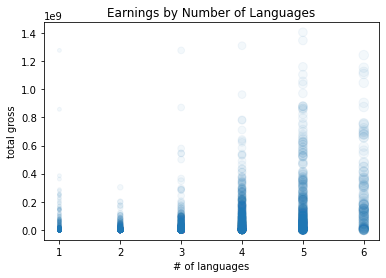

In [49]:
# view a plot excluding movies produced in more than 6 languages
movie_langs[movie_langs['#_of_languages'] <= 6].plot.scatter(x= '#_of_languages', y = 'total_gross', s= movie_langs[movie_langs['#_of_languages'] <= 6]['#_of_languages']*15, alpha= .05) 
plt.xlabel('# of languages')
plt.ylabel('total gross')
plt.title('Earnings by Number of Languages')
# save the plot
plt.savefig('images/under_6_count_scatter');

Again, although there is an exception (single language movies earned more than movies in two languages), there is a clear pattern of increased earnings as the number of available languages increases. (Although column 5 has darker shaded areas higher on the plot than column 6, when taking into account that column 5 has a much darker area towards the bottom than column 6, it becomes apparent that column 5 has more movies, but movies in column 6 tend to earn more money [as evident from the bar plot above].)
***

## Conclusions

Three recomendations based on the above anaysis are:
* Movies produced should be in one of the top genres for earnings. (Publishing movies of only the highest earning genre doesn't seem like a great idea for a company's reputation; it seems dull & unexciting & may drive away business.)  
The 5 highest earning genres are (in order of descending profitability):
    * sci-fi
    * adventure
    * animation
    * action
    * fantasy  
* Because movies released in more languages earn more money, the number of languages the movies are available in should be maximized. This is markedly more so when movies are produced for a foreign market. *Further exploration is needed to understand why movies available in 1 language earn more than movies in 2.*
  
* Films in certain languages are more profitable, therefore, production (especially for foreign markets) should focus on movies in those languages. It should be noted that foreign earnings of a movie by language is certainly influenced by the region in which a movie is released & should be taken into account when determining the release language of a given film.  
The top earning languages are (in descending order):
    * Dutch
    * Persian
    * Hindi
    * Mandarin Chinese
    




It should be noted that that my analysis only examined what movies grossed the most money, but did not take into account that certain movies may have higher costs (e.g. production, marketing), thus reducing actual profit. Further analysis should include that information to determine which movies are truly the most profitable.